# Plot maps of momentum fluxes

This notebook produces Figure 2 of the paper.

Author: Brian Green (briangre@stanford.edu)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
from dataclasses import dataclass
import warnings
from scipy.ndimage import label
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import scipy.signal
import datetime
from mpl_toolkits.basemap import Basemap

from tqdm.notebook import tqdm
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

warnings.simplefilter("ignore")
    
# Replace Basemap with Cartopy:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

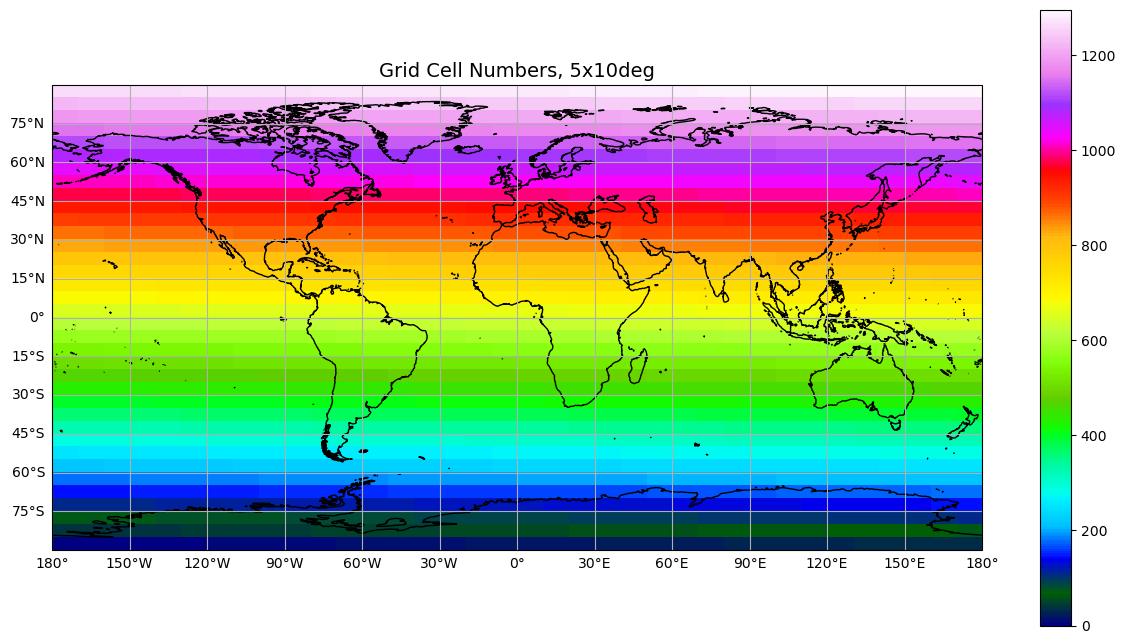

In [2]:
# Load in the momentum fluxes and apply a "grid cell number" to each value

flights = pd.read_feather('segments_2dayslong_fluxes_paper.feather')
flights['month'] = flights.time.apply(lambda x: x.month)
flights['year'] = flights.time.apply(lambda x: x.year)

nlat_grid = 36 # 5deg, 90N to 90S
nlon_grid = 36 # 10deg, 180W to 180E 
lat_grid = 5*np.arange(nlat_grid) - 87.5
lon_grid = 10*np.arange(nlon_grid) - 175
min_n_obs = 1000

# Create a cell "number" for each grid cell, essentially making each cell its own region
grid_cell_numbers = np.arange(nlat_grid*nlon_grid).reshape(nlat_grid,nlon_grid)
grid_cell_numbers = grid_cell_numbers.astype(float)

# Make a list of each grid cell's latitude and longitude
[temp_lat, temp_lon] = np.meshgrid(lat_grid, lon_grid)
temp_lat = np.reshape(temp_lat, nlat_grid*nlon_grid)
temp_lon = np.reshape(temp_lon, nlat_grid*nlon_grid)

# Apply a cell number to each GW packet
data_lat = np.array(flights.latitude)
data_lon = np.array(flights.longitude)
temp = np.reshape(np.transpose(grid_cell_numbers), nlat_grid*nlon_grid)
f = interpolate.NearestNDInterpolator((temp_lat,temp_lon),temp)
# this is how 2D interpolation is done from a grid to a list of points:
data_cellnum = [float(f(*p)) for p in zip(data_lat, data_lon)]
data_cellnum = np.round(np.array(data_cellnum)) # round to the region's integer value
flights['grid_cell_number'] = data_cellnum

# Plot the cell numbers
plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,30))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,15))
data = grid_cell_numbers.copy()
plt.imshow(data, cmap='gist_ncar', extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
plt.title('Grid Cell Numbers, 5x10deg', fontsize=14)
plt.colorbar();
#fig.savefig('temp1.png', format='png', bbox_inches='tight');

In [3]:
# Chop off the first and last two hours of each segment
def dt_start_end(segment):
    
    segment['dt_start'] = (segment.time - segment.time.iloc[0])/pd.Timedelta(1,'hours')
    segment['dt_end'] = (segment.time.iloc[-1] - segment.time)/pd.Timedelta(1,'hours')
    
    return segment

flights = flights.groupby('segment_id').progress_apply(dt_start_end)
flights = flights[flights.dt_start > 2]
flights = flights[flights.dt_end > 2]

  0%|          | 0/938 [00:00<?, ?it/s]

In [4]:
# Delete depressurizations

# My approach, based on running a few depressurizations through a wavelet analysis, is to delete
# both the depressurization and the data within 2 hours (to the nearsest hour, rounding up) or the 
# width of the depressurization, whichever is bigger, on either side of it.
flights['depressurization'] = 0

# Tropical Pacific
# Segment 284 (Flight I-195)
flights.loc[(flights.flight_id == 'I-195') & 
        (flights.time >= np.datetime64('2014-07-09 07:00:00')) &
        (flights.time <= np.datetime64('2014-07-09 15:00:00')), 'depressurization'] = 1

# Segment 7969 (Flight I-488)
flights.loc[(flights.flight_id == 'I-488') & 
        (flights.time >= np.datetime64('2015-05-21 18:00:00')) &
        (flights.time <= np.datetime64('2015-05-22 10:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-488') & 
        (flights.time >= np.datetime64('2015-05-23 04:00:00')) &
        (flights.time <= np.datetime64('2015-05-23 16:00:00')), 'depressurization'] = 1

# Segment 8041 (Flight I-490)
flights.loc[(flights.flight_id == 'I-490') & 
        (flights.time >= np.datetime64('2015-06-24 07:00:00')) &
        (flights.time <= np.datetime64('2015-06-24 13:00:00')), 'depressurization'] = 1



# Tropical Atlantic
# Segment 6506 (Flight I-436)
flights.loc[(flights.flight_id == 'I-436') & 
        (flights.time >= np.datetime64('2015-04-09 01:00:00')) &
        (flights.time <= np.datetime64('2015-04-09 10:00:00')), 'depressurization'] = 1

# Segment 8957 (Flight NR-215)
flights.loc[(flights.flight_id == 'NR-215') & 
        (flights.time >= np.datetime64('2016-02-19 00:00:00')) &
        (flights.time <= np.datetime64('2016-02-19 13:00:00')), 'depressurization'] = 1



# Indian Ocean
# Segment 58 (Flight L-002)
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-15 18:00:00')) &
        (flights.time <= np.datetime64('2014-02-16 04:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-20 04:00:00')) &
        (flights.time <= np.datetime64('2014-02-21 08:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-26 20:00:00')) &
        (flights.time <= np.datetime64('2014-02-27 01:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-02-28 10:00:00')) &
        (flights.time <= np.datetime64('2014-03-01 04:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'L-002') & 
        (flights.time >= np.datetime64('2014-03-03 04:00:00')) &
        (flights.time <= np.datetime64('2014-03-04 06:00:00')), 'depressurization'] = 1

# Segment 5672 (Flight I-361)
flights.loc[(flights.flight_id == 'I-361') & 
        (flights.time >= np.datetime64('2015-01-26 09:00:00')) &
        (flights.time <= np.datetime64('2015-01-27 09:00:00')), 'depressurization'] = 1



# Extratropical Pacific
# Segment 5782 (Flight I-379)
flights.loc[(flights.flight_id == 'I-379') & 
        (flights.time >= np.datetime64('2014-09-22 02:00:00')) &
        (flights.time <= np.datetime64('2014-09-22 08:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-379') & 
        (flights.time >= np.datetime64('2014-09-22 09:00:00')) &
        (flights.time <= np.datetime64('2014-09-22 18:00:00')), 'depressurization'] = 1



# Extratropical Atlantic
# Segment 41 (Flight I-126)
flights.loc[(flights.flight_id == 'I-126') & 
        (flights.time >= np.datetime64('2013-12-23 14:00:00')) &
        (flights.time <= np.datetime64('2013-12-24 03:00:00')), 'depressurization'] = 1



# Southern Ocean
# Segment 543 (Flight I-208)
flights.loc[(flights.flight_id == 'I-208') & 
        (flights.time >= np.datetime64('2014-08-07 23:00:00')) &
        (flights.time <= np.datetime64('2014-08-08 05:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-208') & 
        (flights.time >= np.datetime64('2014-08-09 11:00:00')) &
        (flights.time <= np.datetime64('2014-08-10 00:00:00')), 'depressurization'] = 1

# Segment 1303 (Flight I-248)
flights.loc[(flights.flight_id == 'I-248') & 
        (flights.time >= np.datetime64('2014-07-31 22:00:00')) &
        (flights.time <= np.datetime64('2014-08-01 04:00:00')), 'depressurization'] = 1

# Segment 1585 (Flight I-254)
flights.loc[(flights.flight_id == 'I-254') & 
        (flights.time >= np.datetime64('2014-07-31 11:00:00')) &
        (flights.time <= np.datetime64('2014-07-31 17:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'I-254') & 
        (flights.time >= np.datetime64('2014-08-01 06:00:00')) &
        (flights.time <= np.datetime64('2014-08-01 12:00:00')), 'depressurization'] = 1

# Segment 1985 (Flight I-263)
flights.loc[(flights.flight_id == 'I-263') & 
        (flights.time >= np.datetime64('2014-08-02 02:00:00')) &
        (flights.time <= np.datetime64('2014-08-02 21:00:00')), 'depressurization'] = 1

# Segment 2141 (Flight I-267)
flights.loc[(flights.flight_id == 'I-267') & 
        (flights.time >= np.datetime64('2014-09-18 12:00:00')) &
        (flights.time <= np.datetime64('2014-09-18 19:00:00')), 'depressurization'] = 1

# Segment 3559 (Flight I-292)
flights.loc[(flights.flight_id == 'I-292') & 
        (flights.time >= np.datetime64('2014-11-12 05:00:00')) &
        (flights.time <= np.datetime64('2014-11-13 06:00:00')), 'depressurization'] = 1

# Segment 3816 (Flight I-295)
flights.loc[(flights.flight_id == 'I-295') & 
        (flights.time >= np.datetime64('2014-12-01 06:00:00')) &
        (flights.time <= np.datetime64('2014-12-01 13:00:00')), 'depressurization'] = 1

# Segment 3990 (Flight I-296)
flights.loc[(flights.flight_id == 'I-296') & 
        (flights.time >= np.datetime64('2014-12-26 08:00:00')) &
        (flights.time <= np.datetime64('2014-12-26 14:00:00')), 'depressurization'] = 1

# Segment 4060 (Flight I-298)
flights.loc[(flights.flight_id == 'I-298') & 
        (flights.time >= np.datetime64('2014-07-30 03:00:00')) &
        (flights.time <= np.datetime64('2014-07-30 10:00:00')), 'depressurization'] = 1

# Segment 4623 (Flight I-320)
flights.loc[(flights.flight_id == 'I-320') & 
        (flights.time >= np.datetime64('2014-11-02 05:00:00')) &
        (flights.time <= np.datetime64('2014-11-02 19:00:00')), 'depressurization'] = 1

# Segment 4637 (Flight I-320)
flights.loc[(flights.flight_id == 'I-320') & 
        (flights.time >= np.datetime64('2014-11-29 11:00:00')) &
        (flights.time <= np.datetime64('2014-11-29 19:00:00')), 'depressurization'] = 1

# Segment 5216 (Flight I-338)
flights.loc[(flights.flight_id == 'I-338') & 
        (flights.time >= np.datetime64('2014-08-24 04:00:00')) &
        (flights.time <= np.datetime64('2014-08-24 17:00:00')), 'depressurization'] = 1

# Segment 6884 (Flight M-051)
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-01-25 22:00:00')) &
        (flights.time <= np.datetime64('2015-01-26 10:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-02-01 19:00:00')) &
        (flights.time <= np.datetime64('2015-02-02 10:00:00')), 'depressurization'] = 1

# Segment 6885 (Flight M-051)
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-02-05 12:00:00')) &
        (flights.time <= np.datetime64('2015-02-06 09:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'M-051') & 
        (flights.time >= np.datetime64('2015-02-06 15:00:00')) &
        (flights.time <= np.datetime64('2015-02-07 08:00:00')), 'depressurization'] = 1

# Segment 7020 (Flight M-054)
flights.loc[(flights.flight_id == 'M-054') & 
        (flights.time >= np.datetime64('2015-03-31 20:00:00')) &
        (flights.time <= np.datetime64('2015-04-01 08:00:00')), 'depressurization'] = 1
flights.loc[(flights.flight_id == 'M-054') & 
        (flights.time >= np.datetime64('2015-04-02 14:00:00')) &
        (flights.time <= np.datetime64('2015-04-02 22:00:00')), 'depressurization'] = 1



# Delete the depressurizations
flights = flights[flights.depressurization == 0]
flights = flights.drop(columns = 'depressurization')

In [5]:
# Calculate quantities on the lat-lon grid, using the grid cell numbers from earlier

n_obs_grid = np.zeros(shape=(nlat_grid,nlon_grid))
total_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
zonal_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
meridional_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
eastward_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
westward_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
northward_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
southward_flux_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
eastward_flux_grid_HF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
westward_flux_grid_HF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
northward_flux_grid_HF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
southward_flux_grid_HF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
eastward_flux_grid_MF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
westward_flux_grid_MF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
northward_flux_grid_MF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
southward_flux_grid_MF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
eastward_flux_grid_LF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
westward_flux_grid_LF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
northward_flux_grid_LF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
southward_flux_grid_LF = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
u_smooth_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
v_smooth_grid = np.nan*np.ones(shape=(nlat_grid,nlon_grid))
    
for i in np.arange(nlat_grid):
    for j in np.arange(nlon_grid):
            
        temp = flights[flights.grid_cell_number == grid_cell_numbers[i,j]]
        n_obs_grid[i,j] = temp.shape[0]
        temp_flux = np.sqrt((temp.flux_east - temp.flux_west)**2 + (temp.flux_north - temp.flux_south)**2)
        total_flux_grid[i,j] = np.nanmean(temp_flux)
        zonal_flux_grid[i,j] = np.nanmean(temp.flux_east + temp.flux_west)
        meridional_flux_grid[i,j] = np.nanmean(temp.flux_south + temp.flux_north)
        eastward_flux_grid[i,j] = np.nanmean(temp.flux_east)
        westward_flux_grid[i,j] = np.nanmean(temp.flux_west)
        southward_flux_grid[i,j] = np.nanmean(temp.flux_south)
        northward_flux_grid[i,j] = np.nanmean(temp.flux_north)
        eastward_flux_grid_HF[i,j] = np.nanmean(temp.flux_east_HF)
        westward_flux_grid_HF[i,j] = np.nanmean(temp.flux_west_HF)
        southward_flux_grid_HF[i,j] = np.nanmean(temp.flux_south_HF)
        northward_flux_grid_HF[i,j] = np.nanmean(temp.flux_north_HF)
        eastward_flux_grid_MF[i,j] = np.nanmean(temp.flux_east_MF)
        westward_flux_grid_MF[i,j] = np.nanmean(temp.flux_west_MF)
        southward_flux_grid_MF[i,j] = np.nanmean(temp.flux_south_MF)
        northward_flux_grid_MF[i,j] = np.nanmean(temp.flux_north_MF)
        eastward_flux_grid_LF[i,j] = np.nanmean(temp.flux_east_LF)
        westward_flux_grid_LF[i,j] = np.nanmean(temp.flux_west_LF)
        southward_flux_grid_LF[i,j] = np.nanmean(temp.flux_south_LF)
        northward_flux_grid_LF[i,j] = np.nanmean(temp.flux_north_LF)
        u_smooth_grid[i,j] = np.nanmean(temp.u_smooth)
        v_smooth_grid[i,j] = np.nanmean(temp.v_smooth)

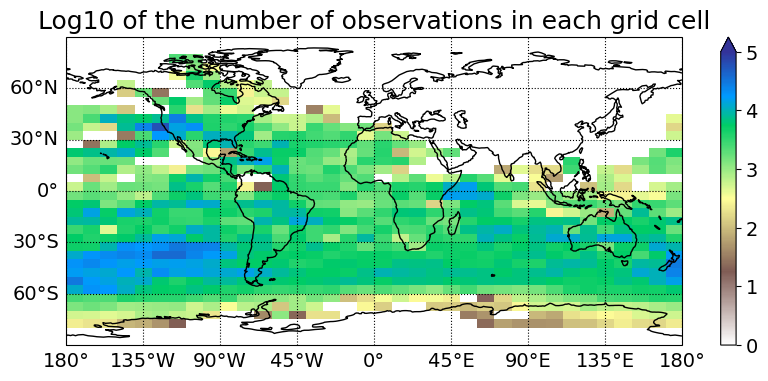

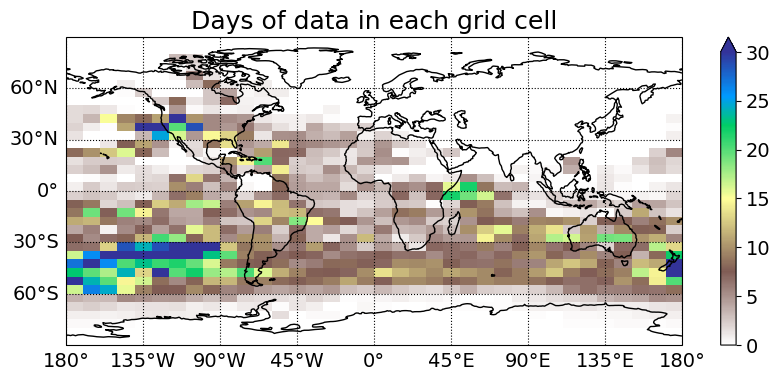

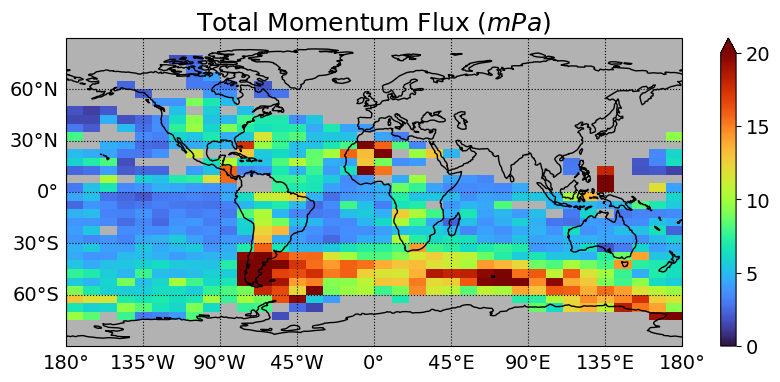

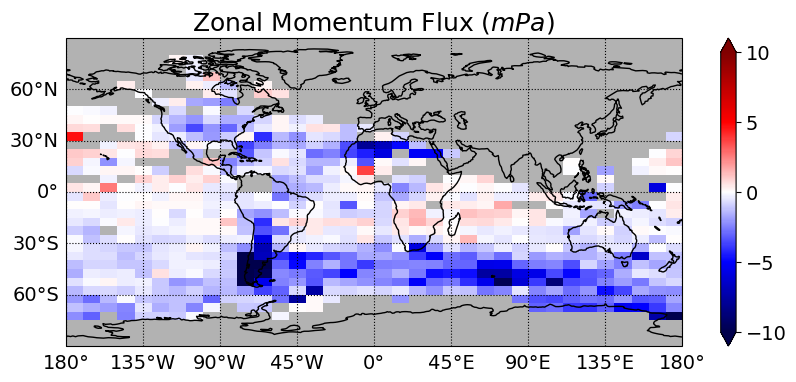

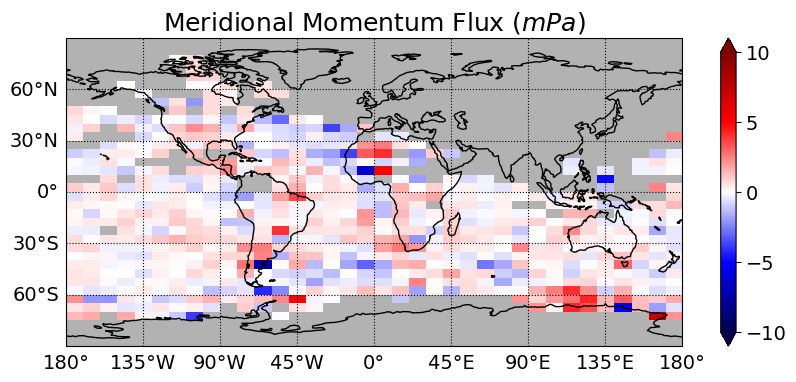

In [6]:
# Plots of the time-mean fluxes

min_n_obs = 500 # only plot values for grid cells with at least this number of observations

plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,30))
data = n_obs_grid.copy()
plt.imshow(np.log10(data), cmap='terrain_r', extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.title('Log10 of the number of observations in each grid cell', fontsize=18)
plt.clim(0,5)
cbar = plt.colorbar(extend = 'max')
cbar.ax.tick_params(labelsize=14);
#plt.savefig('temp1.png', format='png', bbox_inches='tight');

plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,30))
data = n_obs_grid.copy()
plt.imshow(data/(60*24/2), cmap='terrain_r', extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.title('Days of data in each grid cell', fontsize=18)
plt.clim(0,30)
cbar = plt.colorbar(extend = 'max')
cbar.ax.tick_params(labelsize=14);
#plt.savefig('temp1.pdf', format='pdf', bbox_inches='tight');

plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,30))
data = 1000*total_flux_grid.copy()
data[n_obs_grid < min_n_obs] = np.nan
cmap = matplotlib.cm.turbo
cmap.set_bad(color=[0.7,0.7,0.7])
plt.imshow(data, cmap=cmap, extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.title('Total Momentum Flux ($mPa$)', fontsize=18)
plt.clim(0,20)
cbar = plt.colorbar(extend = 'max')
cbar.ax.tick_params(labelsize=14);
#plt.savefig('temp1.pdf', format='pdf', bbox_inches='tight');

plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,30))
data = 1000*zonal_flux_grid.copy()
data[n_obs_grid < min_n_obs] = np.nan
cmap = matplotlib.cm.seismic
cmap.set_bad(color=[0.7,0.7,0.7])
plt.imshow(data, cmap=cmap, extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.title('Zonal Momentum Flux ($mPa$)', fontsize=18)
plt.clim(-10,10)
cbar = plt.colorbar(extend = 'both')
cbar.ax.tick_params(labelsize=14);
#plt.savefig('temp9.pdf', format='pdf', bbox_inches='tight');

plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,30))
data = 1000*meridional_flux_grid.copy()
data[n_obs_grid < min_n_obs] = np.nan
cmap = matplotlib.cm.seismic
cmap.set_bad(color=[0.7,0.7,0.7])
plt.imshow(data, cmap=cmap, extent=(-180,180,90,-90), transform=ccrs.PlateCarree())
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.title('Meridional Momentum Flux ($mPa$)', fontsize=18)
plt.clim(-10,10)
cbar = plt.colorbar(extend = 'both')
cbar.ax.tick_params(labelsize=14);
#plt.savefig('temp10.pdf', format='pdf', bbox_inches='tight');

Area-weighted zonal fluxes (mPa):
30-60S: -2.5118036274808158
30-60N: -0.6226127957420521
15S-15N: -0.2836849900074097

Area-weighted meridional fluxes (mPa):
Northern Hemisphere: 0.013954892569686246
Southern Hemisphere: 0.24378382479944494

North Africa flights
Number of flights, segments: 13 17
Segment IDs: [   44  7074  7115  7485  7493  7595  7597  7687  8703  8878  8879  9045
  9220  9667  9815  9817 17612]

Andes flights
Number of flights, segments: 88 136
Segment IDs: [   103    105    106    107    108    109    110    111    112    113
    134    140    146    151    152    164    515    537    557    573
    691    815    829    852    896    930    938   1068   1079   1099
   1127   1224   1313   1319   1479   1513   1515   1529   1550   1566
   1570   1585   1591   1595   1600   1606   1623   1627   1629   1782
   2017   2062   2103   2213   2248   2257   2283   2382   2466   2559
   2583   2682   2751   2771   2916   2924   2962   2969   2972   3004
   3021   3025   3029 

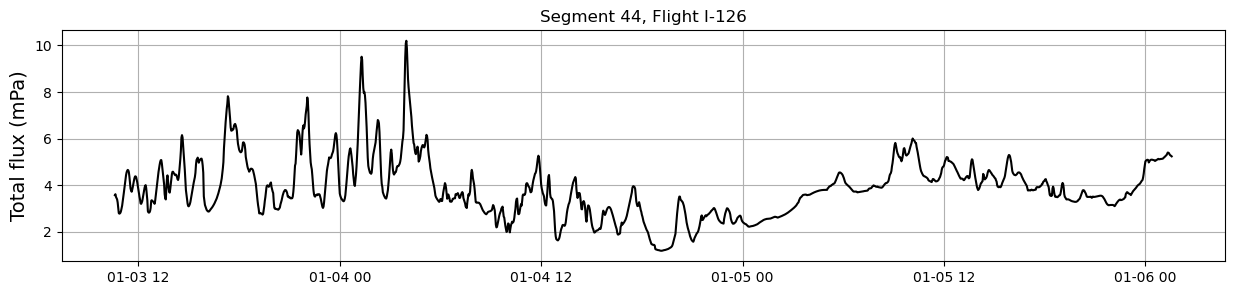

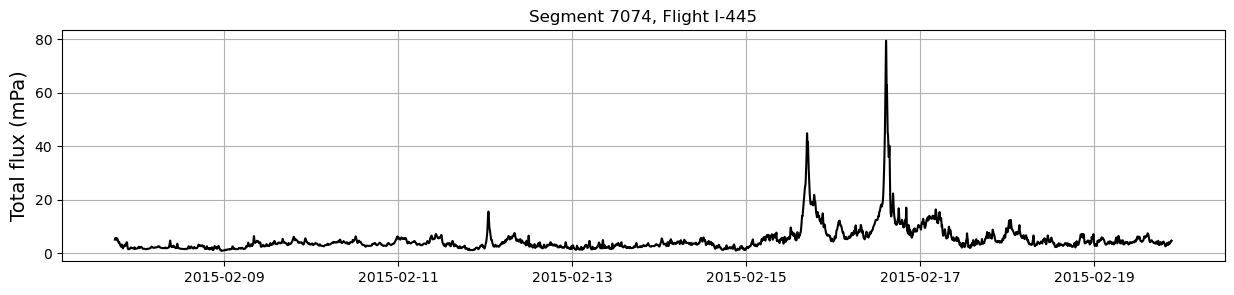

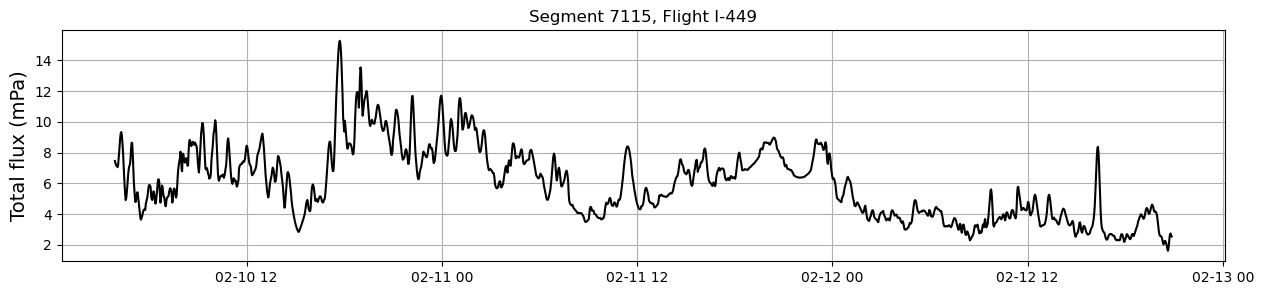

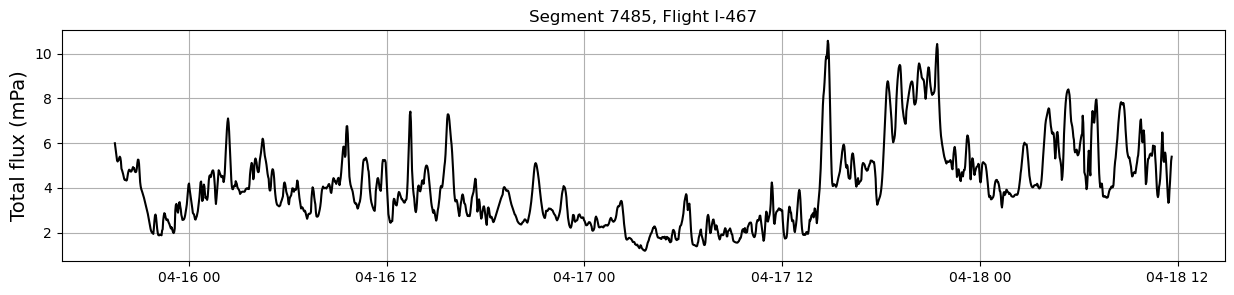

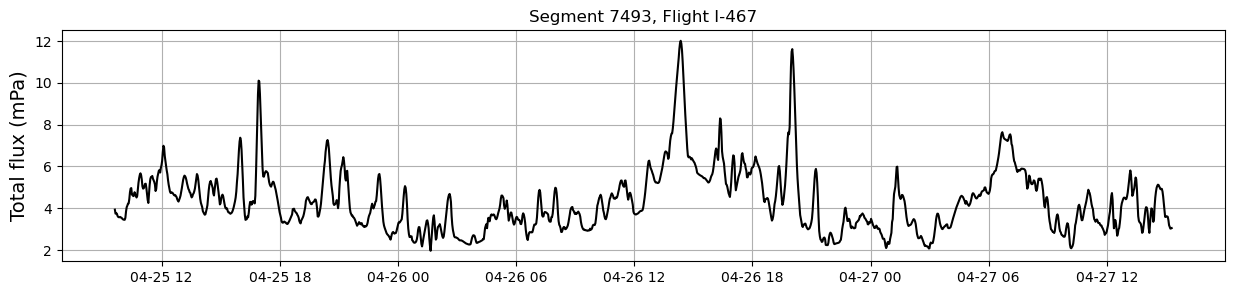

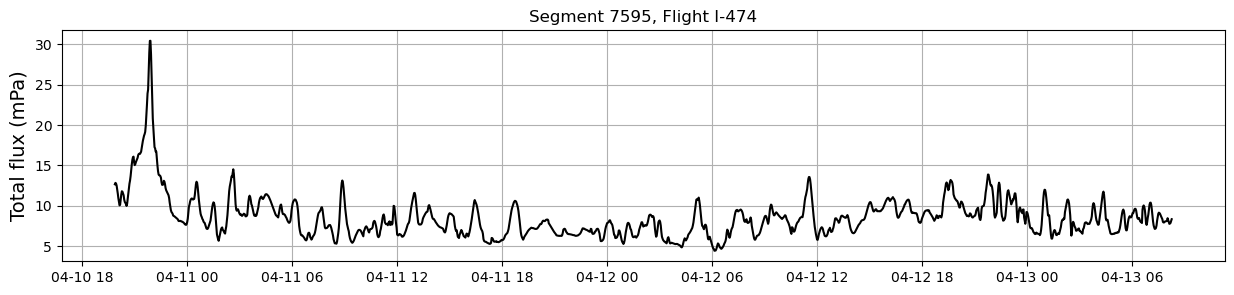

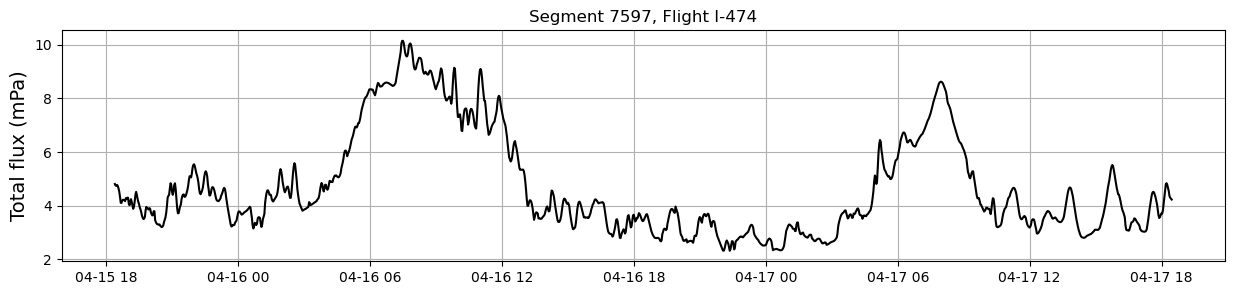

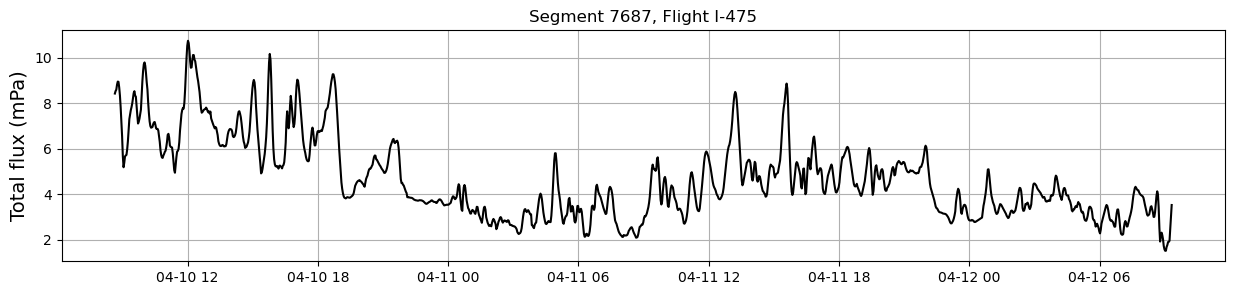

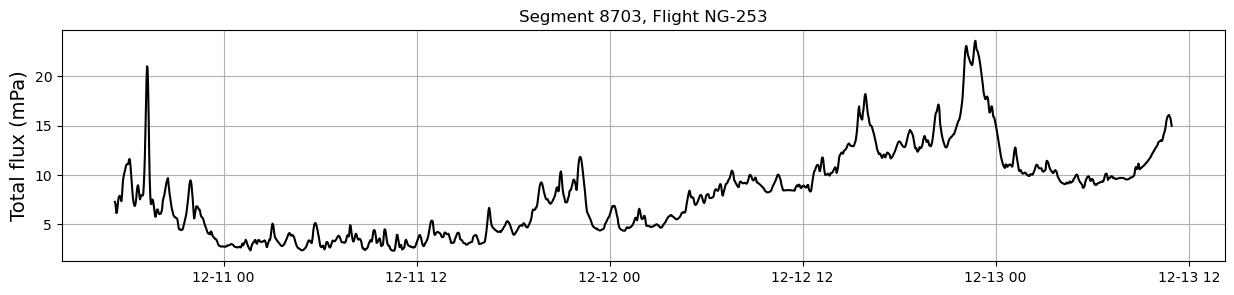

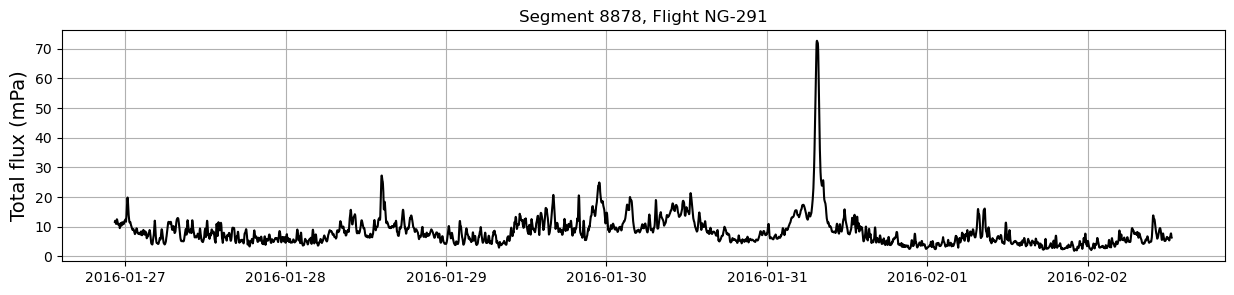

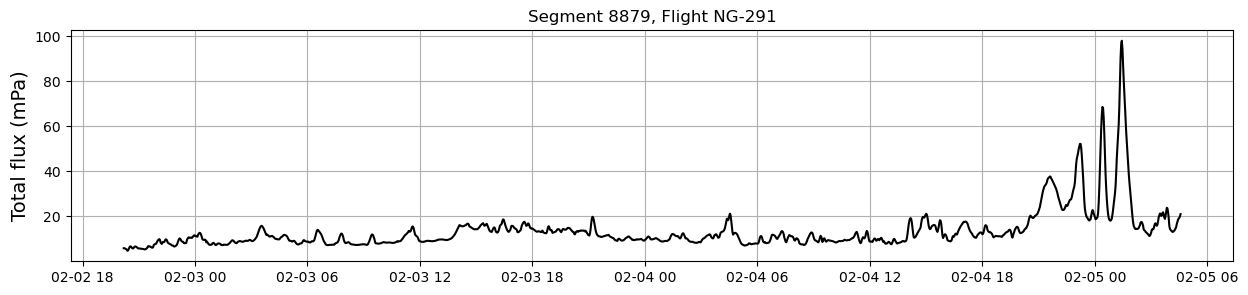

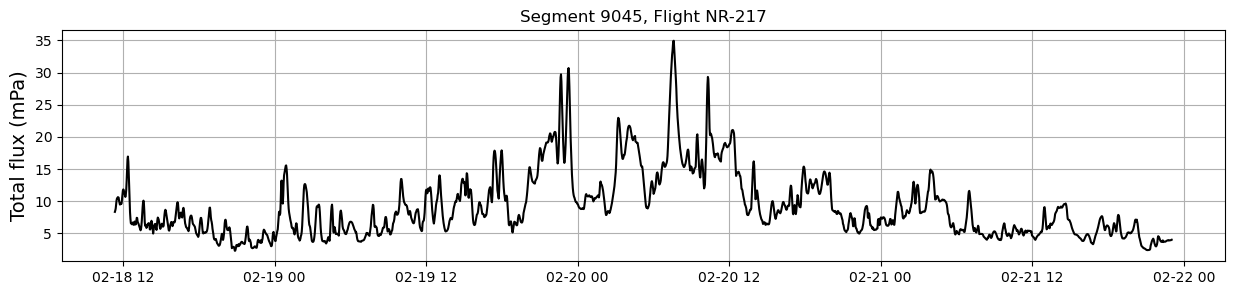

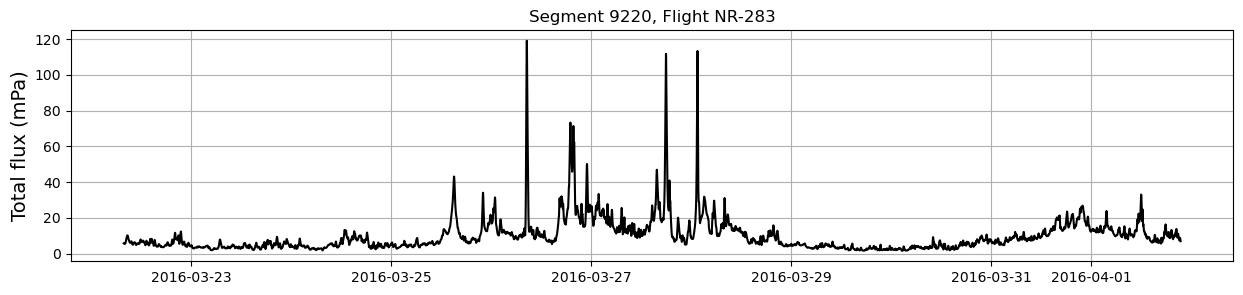

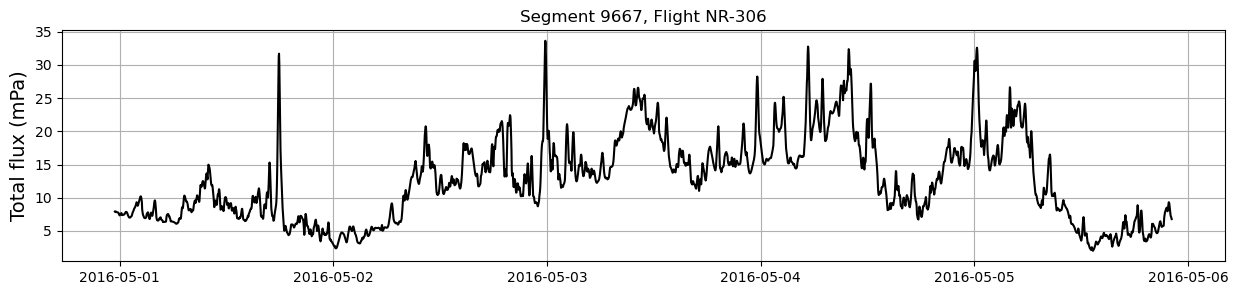

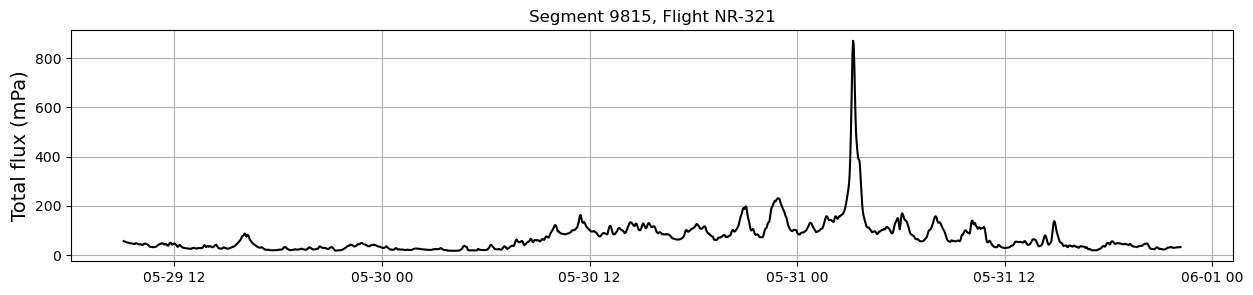

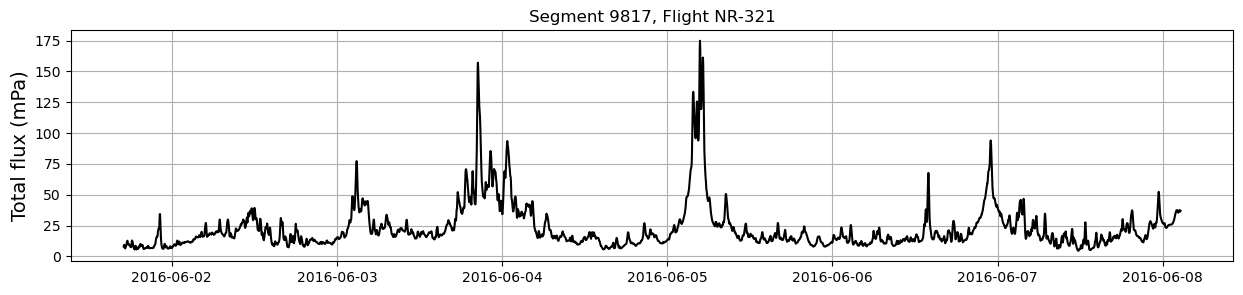

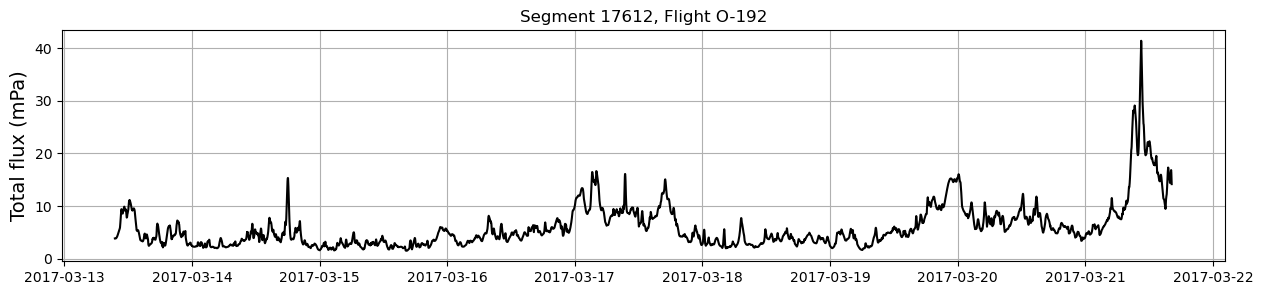

In [8]:
# Calculations supporting the text in Section 3 (global maps) of the manuscript

# Area-weighted flux in latitude bands
data = 1000*zonal_flux_grid.copy()
data[n_obs_grid < min_n_obs] = np.nan
weighting = np.tile(np.cos(np.pi*lat_grid/180),(36,1)).swapaxes(0,1)
weighting = weighting*data/data
mean_30_60S = np.nansum(data[6:12,:]*weighting[6:12,:])/np.nansum(weighting[6:12,:])
mean_30_60N = np.nansum(data[24:30,:]*weighting[24:30,:])/np.nansum(weighting[24:30,:])
mean_15S_15N = np.nansum(data[15:21,:]*weighting[15:21,:])/np.nansum(weighting[15:21,:])
print('Area-weighted zonal fluxes (mPa):')
print('30-60S:', mean_30_60S)
print('30-60N:', mean_30_60N)
print('15S-15N:', mean_15S_15N)
print('')

data = 1000*meridional_flux_grid.copy()
data[n_obs_grid < min_n_obs] = np.nan
weighting = np.tile(np.cos(np.pi*lat_grid/180),(36,1)).swapaxes(0,1)
weighting = weighting*data/data
mean_NH = np.nansum(data[18:,:]*weighting[18:,:])/np.nansum(weighting[18:,:])
mean_SH = np.nansum(data[:18,:]*weighting[:18,:])/np.nansum(weighting[:18,:])
print('Area-weighted meridional fluxes (mPa):')
print('Northern Hemisphere:', mean_NH)
print('Southern Hemisphere:', mean_SH)
print('')

# Balloons flying over North Africa
lat_box_min = 15
lat_box_max = 30
lon_box_min = -10
lon_box_max = 20
lon_weighting = 1 # see the explanation for the Pacific
flights[['in_box1','in_box2','in_box3','in_box4']] = 0
flights.loc[flights.latitude >= lat_box_min, 'in_box1'] = 1
flights.loc[flights.latitude < lat_box_max, 'in_box2'] = 1
flights.loc[flights.longitude >= lon_box_min, 'in_box3'] = 1*lon_weighting
flights.loc[flights.longitude < lon_box_max, 'in_box4'] = 1*lon_weighting
flights['in_box'] = flights.in_box1 + flights.in_box2 + flights.in_box3 + flights.in_box4
segments_to_select = flights[flights.in_box == 4].segment_id.unique()
flights_in_box = flights[flights.segment_id.isin(segments_to_select)].copy()
flights = flights.drop(columns=['in_box1','in_box2','in_box3','in_box4','in_box'])
print('North Africa flights')
print('Number of flights, segments:', flights_in_box.flight_id.nunique(), flights_in_box.segment_id.nunique())
print('Segment IDs:', flights_in_box.segment_id.unique())
print('')
# Calculate the total flux and plot each segment
segment_ids_temp = flights_in_box.segment_id.unique()
for i in np.arange(flights_in_box.segment_id.nunique()):
    temp_segment = flights_in_box[flights_in_box.segment_id == segment_ids_temp[i]]
    flux_tot = 1000*np.sqrt((temp_segment.flux_east - temp_segment.flux_west)**2 + 
                            (temp_segment.flux_north - temp_segment.flux_south)**2)
    plt.figure(figsize=(15,3))
    plt.plot(temp_segment.time,flux_tot,'k')
    plt.grid()
    plt.title(f'Segment {temp_segment.segment_id.iloc[0]}, Flight {temp_segment.flight_id.iloc[0]}')
    plt.ylabel('Total flux (mPa)', fontsize=14);
    
# Balloons flying over the Andes
lat_box_min = -55
lat_box_max = -35
lon_box_min = -80
lon_box_max = -60
lon_weighting = 1 # see the explanation for the Pacific
flights[['in_box1','in_box2','in_box3','in_box4']] = 0
flights.loc[flights.latitude >= lat_box_min, 'in_box1'] = 1
flights.loc[flights.latitude < lat_box_max, 'in_box2'] = 1
flights.loc[flights.longitude >= lon_box_min, 'in_box3'] = 1*lon_weighting
flights.loc[flights.longitude < lon_box_max, 'in_box4'] = 1*lon_weighting
flights['in_box'] = flights.in_box1 + flights.in_box2 + flights.in_box3 + flights.in_box4
segments_to_select = flights[flights.in_box == 4].segment_id.unique()
flights_in_box = flights[flights.segment_id.isin(segments_to_select)].copy()
flights = flights.drop(columns=['in_box1','in_box2','in_box3','in_box4','in_box'])
print('Andes flights')
print('Number of flights, segments:', flights_in_box.flight_id.nunique(), flights_in_box.segment_id.nunique())
print('Segment IDs:', flights_in_box.segment_id.unique())
print('')
# Mean momentum flux in the grid box
temp = flights_in_box[flights_in_box.latitude >= lat_box_min].copy()
temp = temp[temp.latitude < lat_box_max]
temp = temp[temp.longitude >= lon_box_min]
temp = temp[temp.longitude < lon_box_max]
temp2 = np.array(1000*(temp.flux_east + temp.flux_west))
temp3 = np.array(1000*np.sqrt((temp.flux_east - temp.flux_west)**2 + (temp.flux_north - temp.flux_south)**2))
print('Mean zonal momentum flux:', np.nanmean(temp2))
print('Mean total momentum flux:', np.nanmean(temp3))
# Minimum zonal momentum flux in a grid cell
data = 1000*zonal_flux_grid.copy()
print('Minimum zonal momentum flux in a 5x10 degree grid cell (mPa):', np.nanmin(data[7:11,10:12]))
# Maximum total momentum flux in a grid cell
data = 1000*total_flux_grid.copy()
print('Maximum total momentum flux in a 5x10 degree grid cell (mPa):', np.nanmax(data[7:11,10:12]))
# Number of flights with westward momentum fluxes greater than 100 mPa in that grid box
temp = temp[-1000*temp.flux_west > 50]
print('Number of flights with westward momentum fluxes > 50 mPa:', temp.flight_id.nunique())
print('Largest westward momentum flux (mPa):', -1000*temp.flux_west.min())